**AI for Generating Recipes**

**What?**

With the closing of many restaurants during the pandemic I’ve spent hours searching various websites looking for the next recipe to cook in my kitchen. While I wait for my water to boil, I would watch YouTube videos of people using AI to create original poems, so I thought - why not recipes?! For my project this semester, I would like to create an AI that generates recipes given a list of ingredients I have in my kitchen. 

**How?**

I did not start this project by myself, but followed a tutorial by Oleksii Trekhleb, a Software Engineer at Uber. This is my version for a “Hello World”. The project includes a Long Short-Term Memory (LSTM) Recurrent Neural Network that is trained with over 250,000+ recipes. (I chose a different database than the one Oleksii uses with 100,000+ recipes). 

RNN’s are most commonly used for natural language processing because they can store some context of the sequence in internal memory. This becomes useful in our use case: if the first word of the sequence was *Preheat*, the RNN may suggest the next word to be oven (instead of *microwave*) because *Preheat* is already inside the internal memory and we’ve learned through training the common context of this word. This can also be done on a character-level, which is what I used for my project.

LSTM is used because we want to understand as much of the previous context in order to suggest the next word or character to use. A neural network’s ability to understand long range dependencies in data is important for sentence structures. 
I converted my Pandas dataset to TensorFlow and used TensorFlow’s Keras API to build my LSTM RNN model. After cleaning my dataset, tokenizing by characters, padding my sequences, and building my Sequential Embedded LSTM model, I  then split my dataset into 64 batches, and trained my model into 20 epoches, with 200 steps for each epoch. We calculated loss with our training data using a Keras optimizer and Sparse Categorical Cross Entropy. It took about 3 days to train on my personal computer and here is the improvement we got to:
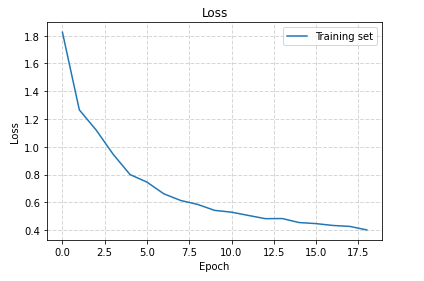

Here is a generated Recipe:

>Attempt: "B" + 1.0
>-----------------------------------
>📗 Bjuice cookies
>
>🥕
>- butter
>- eggs
>- shulk wine vinegar
>- egg
>- olive oil
>- semi-sweet peas
>- chocolate sauce
>- frozen chopped pickling salt

>📝
>- place bread fuffining pieces
>- in a small bowl 
>- combine butter in large pie pan 
>- alternately away from pan
>- cover with laffle mixture in each prepare
>- remove from then sides and serve immediately
>- mix the soup in the bruscheets with nonstick cooking spray
>- microwave for 12 minutes or until softened
>- dein your meat

**What’s Next:**

Our model needs longer time to train, as seen by the poor grammar and English in our example recipes. Next, I hope to:
1. Train the model longer
2. Eliminate duplicates in the ingredients section
3. Connect the Ingredients to the Instructions: ensure that the items mentioned in the instructions section are the only items in the ingredients list. 


Tuturial: https://www.kdnuggets.com/2020/07/generating-cooking-recipes-using-tensorflow.html
 
Dataset: 
Inlcudes 250,000+ recipes with indredient porportions
https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

In [1]:
# Packages for training the model and working with the dataset.
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Utility/helper packages.
import platform
import time
import pathlib
import os


In [2]:
data_dir = r'C:\Users\MEOW\Dropbox\JupyterProjects'
file_name = data_dir + '\RAW_recipes.csv'
dataset_raw = pd.read_csv(file_name)
dataset_raw.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [3]:
def recipe_validate_required_fields(recipe):
    recipe = recipe[1]
    required_keys = ["name", "ingredients", "steps"]

    if recipe.empty:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

dataset_validated = [recipe for recipe in dataset_raw.iterrows() if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of incomplete recipes', len(dataset_raw) - len(dataset_validated))


Dataset size BEFORE validation 231637
Dataset size AFTER validation 231637
Number of incomplete recipes 0


In [4]:
print(dataset_validated[5][1]["ingredients"][1])

'


In [5]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

def recipe_to_string(recipe):
    recipe = recipe[1]
    
    title = recipe['name']
    ingredients = recipe['ingredients']
    instructions = recipe['steps']
    
    ingredients_string = ''
    for ingredient in ingredients.strip("[]").split(', '):
        if ingredient:
            ingredient = ingredient.replace("'", "")
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions.strip('][').split(', '):
        if instruction:
            instruction = instruction.replace("'", "")
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 arriba   baked winter squash mexican style

🥕

• winter squash
• mexican seasoning
• mixed spice
• honey
• butter
• olive oil
• salt

📝

▪︎ make a choice and proceed with recipe
▪︎ depending on size of squash 
▪︎ cut into half or fourths
▪︎ remove seeds
▪︎ for spicy squash 
▪︎ drizzle olive oil or melted butter over each cut squash piece
▪︎ season with mexican seasoning mix ii
▪︎ for sweet squash 
▪︎ drizzle melted honey 
▪︎ butter 
▪︎ grated piloncillo over each cut squash piece
▪︎ season with sweet mexican spice mix
▪︎ bake at 350 degrees 
▪︎ again depending on size 
▪︎ for 40 minutes up to an hour 
▪︎ until a fork can easily pierce the skin
▪︎ be careful not to burn the squash especially if you opt to use sugar or butter
▪︎ if you feel more comfortable 
▪︎ cover the squash with aluminum foil the first half hour 
▪︎ give or take 
▪︎ of baking
▪︎ if desired 
▪︎ season with salt



Recipe #2
---------
📗 a bit different  breakfast pizza

🥕

• prepared pizza crust
•

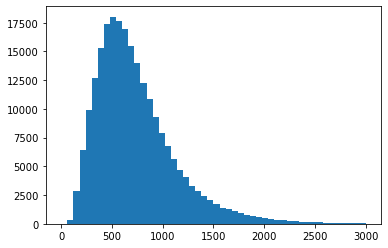

In [6]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, range=(0, 3000), bins=50)
plt.show()

In [7]:
MAX_RECIPE_LENGTH = 1000
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered)) 

Dataset size BEFORE filtering:  231637
Dataset size AFTER filtering:  184912
Number of eliminated recipes:  46725


TOKENIZING characters


In [8]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 184913,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 184912, " ": 17344427, "a": 6335895, "r": 5402351, "i": 5470618, "b": 1564095, "k": 1055102, "e": 9203946, "d": 3064891, "w": 1125935, "n": 5424288, "t": 5763636, "s": 4764101, "q": 68019, "u": 2543253, "h": 2700888, "m": 2060425, "x": 286585, "c": 2995456, "y": 749620, "l": 3863528, "\\n": 5003042, "\\ud83e\\udd55": 184912, "\\u2022": 1536648, "o": 5793395, "g": 1913626, "p": 2319650, "v": 786007, "\\ud83d\\udcdd": 184912, "\\u25aa": 2172010, "\\ufe0e": 2172010, "z": 123047, "f": 1245105, "3": 139525, "5": 158187, "0": 170192, "4": 78680, "2": 146405, "1": 206298, "&": 23436, "-": 182412, "6": 20688, "8": 28552, "j": 144212, "\\"": 52228, "^": 56, "/": 60855, "!": 19222, "9": 20903, ":": 16551, "7": 20903, "@": 600, "%": 1563, ".": 477, ")": 1457, "]": 313, "(": 590, "~": 522, "{": 72, "\\\\": 339, ",":

In [9]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  76


In [10]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

t
g


In [11]:
tokenizer.word_index[' ']

1

In [12]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])


['', ' ', 'e', 'a', 'o', 't', 'i', 'n', 'r', '\n', 's', 'l', 'd', 'c', 'h', 'u', 'p', '▪', '︎', 'm', 'g', 'b', '•', 'f', 'w', 'k', 'v', 'y', 'x', '1', '📗', '🥕', '📝', '-', '0', '5', '2', 'j', '3', 'z', '4', 'q', '/', '"', '8', '&', '9', '7', '6', '!', ':', '%', ')', ',', '@', '(', '~', '.', '#', '\\', '[', ']', '=', '+', '?', '`', '{', '}', '>', '^', '_', '<', '$', '|', '*', '␣']


In [13]:
tokenizer.texts_to_sequences(['📗 yes'])

[[30, 1, 27, 2, 10]]

Vectorizing 

In [14]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized)) 

Vectorized dataset size 184912


In [15]:
import re

def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = re.sub(r'(?<=\S)\s(?=\S)', '', recipe_stringified).replace("   ", " ")
    print(recipe_stringified)
    
recipe_sequence_to_string(dataset_vectorized[0])


📗 arriba   baked winter squash mexican style 
 
 🥕 
 
 • winter squash 
 • mexican seasoning 
 • mixed spice 
 • honey 
 • butter 
 • olive oil 
 • salt 
 
 📝 
 
 ▪︎ make a choice and proceed with recipe 
 ▪︎ depending on size of squash 
 ▪︎ cut into half or fourths 
 ▪︎ remove seeds 
 ▪︎ for spicy squash 
 ▪︎ drizzle olive oil or melted butter over each cut squash piece 
 ▪︎ season with mexican seasoning mix ii 
 ▪︎ for sweet squash 
 ▪︎ drizzle melted honey 
 ▪︎ butter 
 ▪︎ grated piloncillo over each cut squash piece 
 ▪︎ season with sweet mexican spice mix 
 ▪︎ bake at 350 degrees 
 ▪︎ again depending on size 
 ▪︎ for 40 minutes up to an hour 
 ▪︎ until a fork can easily pierce the skin 
 ▪︎ be careful not to burn the squash especially if you opt to use sugar or butter 
 ▪︎ if you feel more comfortable 
 ▪︎ cover the squash with aluminum foil the first half hour 
 ▪︎ give or take 
 ▪︎ of baking 
 ▪︎ if desired 
 ▪︎ season with salt 



In [16]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 894
Recipe #2 length: 537
Recipe #3 length: 528
Recipe #4 length: 781
Recipe #5 length: 457
Recipe #6 length: 223
Recipe #7 length: 345
Recipe #8 length: 607
Recipe #9 length: 758
Recipe #10 length: 218


In [17]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 1001
Recipe #1 length: 1001
Recipe #2 length: 1001
Recipe #3 length: 1001
Recipe #4 length: 1001
Recipe #5 length: 1001
Recipe #6 length: 1001
Recipe #7 length: 1001
Recipe #8 length: 1001
Recipe #9 length: 1001


In [18]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (1001,), types: tf.int32>


In [19]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())


Raw recipe:
 [30  1  3 ... 75 75 75] 



Stringified recipe:

📗 arriba   baked winter squash mexican style 
 
 🥕 
 
 • winter squash 
 • mexican seasoning 
 • mixed spice 
 • honey 
 • butter 
 • olive oil 
 • salt 
 
 📝 
 
 ▪︎ make a choice and proceed with recipe 
 ▪︎ depending on size of squash 
 ▪︎ cut into half or fourths 
 ▪︎ remove seeds 
 ▪︎ for spicy squash 
 ▪︎ drizzle olive oil or melted butter over each cut squash piece 
 ▪︎ season with mexican seasoning mix ii 
 ▪︎ for sweet squash 
 ▪︎ drizzle melted honey 
 ▪︎ butter 
 ▪︎ grated piloncillo over each cut squash piece 
 ▪︎ season with sweet mexican spice mix 
 ▪︎ bake at 350 degrees 
 ▪︎ again depending on size 
 ▪︎ for 40 minutes up to an hour 
 ▪︎ until a fork can easily pierce the skin 
 ▪︎ be careful not to burn the squash especially if you opt to use sugar or butter 
 ▪︎ if you feel more comfortable 
 ▪︎ cover the squash with aluminum foil the first half hour 
 ▪︎ give or take 
 ▪︎ of baking 
 ▪︎ if desired 
 ▪︎ seaso

In [20]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((1000,), (1000,)), types: (tf.int32, tf.int32)>


In [21]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 


Input sequence size: 1000
Target sequence size: 1000

Input:   '📗   a r r i b a       b a k e d   w i n t e r   s q u a s h   m e x i c a n   s t y l e \n \n 🥕 \n \n •'
Target:  '  a r r i b a       b a k e d   w i n t e r   s q u a s h   m e x i c a n   s t y l e \n \n 🥕 \n \n •  '


In [22]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))


Step  1
  input: 30 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 3 ('a')
Step  3
  input: 3 ('a')
  expected output: 8 ('r')
Step  4
  input: 8 ('r')
  expected output: 8 ('r')
Step  5
  input: 8 ('r')
  expected output: 6 ('i')
Step  6
  input: 6 ('i')
  expected output: 21 ('b')
Step  7
  input: 21 ('b')
  expected output: 3 ('a')
Step  8
  input: 3 ('a')
  expected output: 1 (' ')
Step  9
  input: 1 (' ')
  expected output: 1 (' ')
Step 10
  input: 1 (' ')
  expected output: 1 (' ')


In [23]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 1000), (64, 1000)), types: (tf.int32, tf.int32)>


In [24]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[30  1 29 ... 75 75 75]
 [30  1 37 ... 75 75 75]
 [30  1  5 ... 75 75 75]
 ...
 [30  1 10 ... 75 75 75]
 [30  1 13 ... 75 75 75]
 [30  1 29 ... 75 75 75]], shape=(64, 1000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 1 29 44 ... 75 75 75]
 [ 1 37  3 ... 75 75 75]
 [ 1  5 14 ... 75 75 75]
 ...
 [ 1 10  1 ... 75 75 75]
 [ 1 13 14 ... 75 75 75]
 [ 1 29 34 ... 75 75 75]], shape=(64, 1000), dtype=int32)


In [25]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           19456     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 76)            77900     
Total params: 5,344,332
Trainable params: 5,344,332
Non-trainable params: 0
_________________________________________________________________


In [26]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 1000, 76) # (batch_size, sequence_length, vocab_size)


In [27]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(1000,)

In [28]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]])))) 

Input:
 '📗   1 4   m i n u t e   m a p l e   c a n d y \n \n 🥕 \n \n •   m a p l e   s y r u p \n •   c r e a m \n'

Next char prediction:
 '! 9 7 ` 9 $ 📗 y 3 ^ 8   e x ! ? " ▪ ( v \n } 8 u b : : 📝 9 2 . o   7 📗 ] ]   w a h & y t l $ • d / {'


In [29]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 

Prediction shape:  (64, 1000, 76)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 1000)
scalar_loss:       4.325919


In [30]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)


In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [32]:
EPOCHS = 20
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 200

history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/20
200/200 [==============================] - 10579s 53s/step - loss: 2.2091
Epoch 3/20
200/200 [==============================] - 12162s 61s/step - loss: 1.3083
Epoch 4/20
200/200 [==============================] - 12042s 60s/step - loss: 1.1297
Epoch 5/20
200/200 [==============================] - 12120s 61s/step - loss: 1.0031
Epoch 6/20
200/200 [==============================] - 12159s 61s/step - loss: 0.8223
Epoch 7/20
200/200 [==============================] - 12455s 62s/step - loss: 0.7764
Epoch 8/20
200/200 [==============================] - 12331s 62s/step - loss: 0.6817
Epoch 9/20
200/200 [==============================] - 12340s 62s/step - loss: 0.6262
Epoch 10/20
200/200 [==============================] - 12284s 61s/step - loss: 0.5804
Epoch 11/20
200/200 [==============================] - 12299s 61s/step - loss: 0.5488
Epoch 12/20
200/200 [==============================] - 12273s 61s/step - loss: 0.5299
Epoch 13/20
200/200 [==============================] - 12269s 

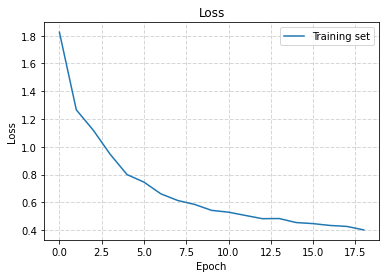

In [33]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)


In [36]:
tf.train.latest_checkpoint(checkpoint_dir)


'tmp/checkpoints\\ckpt_20'

In [40]:
simplified_batch_size = 1

model_simplified = build_model(vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=simplified_batch_size)
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            19456     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 76)             77900     
Total params: 5,344,332
Trainable params: 5,344,332
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_simplified.input_shape

(1, None)

In [42]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [47]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = [ 'A', 'B', 'C']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [48]:
generate_combinations(model_simplified)

Attempt: "A" + 1.0
-----------------------------------
📗 A"odat to banch dough for remaining sasancr lime

🥕

• boneless chicken breasts
• garlic
• fresh basil
• black pepper
• celery
• baby
• plain notstarch

📝

▪︎ combine all ingredients until browned boil 
▪︎ about 25 minutes
▪︎ place leftover venion with cooking spray and brown tall up and fold wo genee
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Attempt: "C" + 1.0
-----------------------------------
📗 C350 / 4 1 / 2 cordities for 20 seconds
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣